In [1]:
import os
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet50
from torchsummary import summary

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics

In [2]:
batch_size = 64

# Load data

In [3]:
train_images = glob.glob('data/Training/**/*.jpg', recursive=True)
test_images = glob.glob('data/Test/**/*.jpg', recursive=True)
labels = glob.glob('data/Training/*')

In [4]:
labels_index = dict([(os.path.basename(label), index) for index, label in enumerate(labels)])
index_label = dict([(index, os.path.basename(label)) for index, label in enumerate(labels)])

In [5]:
class FruitDataset(Dataset):
    def __init__(self, image_path):
        super(FruitDataset, self).__init__()
        self.images_path = image_path
    
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, index):
        image_path = self.images_path[index]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img / 255.
        img = np.transpose(img, (2, 1, 0))
        
        label = labels_index[os.path.basename(os.path.dirname(image_path))]
        return {
            'image': torch.tensor(img, dtype=torch.float32),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [6]:
train_dataset = FruitDataset(train_images)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

test_dataset = FruitDataset(test_images)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=6)

# Build simple module

In [7]:
class FruitClassifer(pl.LightningModule):
    def __init__(self, is_pretrained=False):
        super(FruitClassifer, self).__init__()
        
        self.accuracy = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        
        if not is_pretrained:
            self.classifier = nn.Sequential(
                nn.Conv2d(3, 16, 5),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(),

                nn.Conv2d(16, 32, 5),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(),

                nn.Conv2d(32, 64, 5),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(),

                nn.Conv2d(64, 128, 5),
                nn.MaxPool2d(2, stride=2),
                nn.ReLU(),

                nn.AdaptiveAvgPool2d((1,1)),
                nn.Flatten(),
                nn.Linear(128, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(512, 131)
            )
        else:
            resnet = resnet50(pretrained=True)
            in_features = resnet.fc.in_features
            layers = list(resnet.children())[:-1]

            self.classifier = nn.Sequential(*layers)
            decision_module = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(512, 131)
            )
            self.classifier.add_module('decision_module', decision_module)
        
    def forward(self, x):
        x = self.classifier(x)
        return x
    
    def training_step(self, batch, batch_nb):
        batch_image = batch['image']
        batch_label = batch['label']
        
        logits = self(batch_image)
        loss = F.cross_entropy(logits, batch_label)
        self.accuracy(logits.argmax(dim=1), batch_label)
        self.log('train_acc', self.accuracy, on_step=True, on_epoch=False)
        return loss
    
    def validation_step(self, batch, batch_nb):
        batch_image = batch['image']
        batch_label = batch['label']
        
        logits = self(batch_image)
        val_loss = F.cross_entropy(logits, batch_label)
        
        self.val_acc(logits.argmax(dim=1), batch_label)
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        return val_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [8]:
model = FruitClassifer(is_pretrained=True)

In [9]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0.02,
    patience=3,
    verbose=False,
    mode='max'
)

In [10]:
trainer = pl.Trainer(
    gpus=1, max_epochs=10, 
    progress_bar_refresh_rate=20,
    callbacks=[early_stopping]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [11]:
trainer.fit(model, train_dataloader, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | accuracy   | Accuracy   | 0     
1 | val_acc    | Accuracy   | 0     
2 | classifier | Sequential | 24.6 M
------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.497    Total estimated model params size (MB)


# Evaluation

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
import seaborn as sns

In [13]:
model.to('cuda')
model.eval()

FruitClassifer(
  (accuracy): Accuracy()
  (val_acc): Accuracy()
  (classifier): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
 

In [14]:
y_true = []
y_pred = []

for test_data in test_dataloader:
    with torch.no_grad():
        results = model(test_data['image'].to('cuda'))
    results = F.softmax(results, dim=1)
    results = results.detach().cpu().numpy()
    y_pred.append(results.argmax(axis=1))
    
    y_true.append(test_data['label'].detach().cpu().numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       166
           2       1.00      1.00      1.00       166
           3       1.00      1.00      1.00       164
           4       1.00      1.00      1.00       166
           5       1.00      1.00      1.00       166
           6       1.00      0.98      0.99       246
           7       1.00      1.00      1.00       166
           8       0.90      1.00      0.95       164
           9       0.99      1.00      0.99       232
          10       0.98      1.00      0.99       166
          11       1.00      1.00      1.00       246
          12       1.00      1.00      1.00       166
          13       0.92      1.00      0.96       166
          14       0.75      1.00      0.86       246
          15       1.00      1.00      1.00       153
          16       1.00      1.00      1.00       222
          17       1.00    

In [16]:
matthews_corrcoef(y_true, y_pred)

0.988337732546435

# Inference

In [17]:
class InferenceDataset(Dataset):
    def __init__(self, image_path):
        self.image_path = image_path
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, index):
        image_path = self.image_path[index]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img / 255.
        img = np.transpose(img, (2, 1, 0))
        
        return img

In [18]:
selected_images = np.random.choice(test_images, 15)

In [19]:
inference_dataset = InferenceDataset(selected_images)
inference_dataloader = DataLoader(inference_dataset, batch_size=15, num_workers=6)

In [20]:
results = trainer.predict(model, inference_dataloader)[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


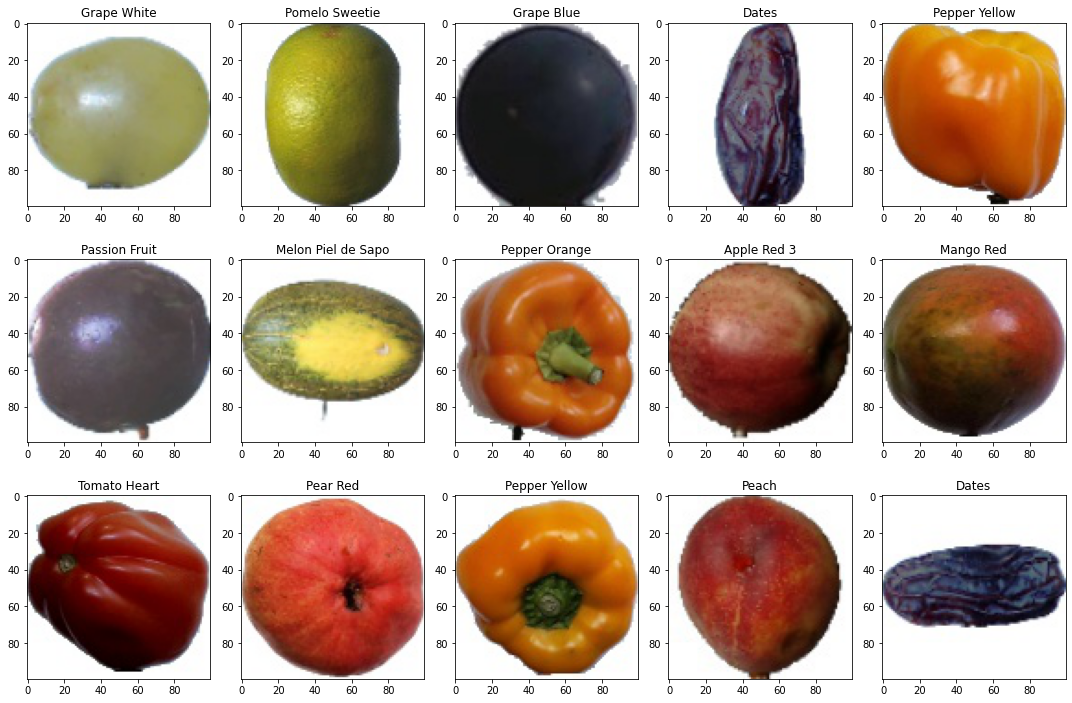

In [21]:
row, column, count = 3, 5, 0
plt.figure(figsize=(15, 10))
for index, image in enumerate(selected_images):
    result = F.softmax(results[index], dim=-1)
    result = result.argmax().detach().cpu().numpy()
    
    count += 1
    plt.subplot(row, column, count)
    plt.title(index_label[result.item()])
    plt.imshow(Image.open(image))
plt.tight_layout()